In [0]:
# Install the PyDrive wrapper & import libraries 
! pip install -U -q PyDrive 

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


     |████████████████████████████████| 993kB 5.0MB/s 


In [0]:

download = drive.CreateFile({'id': '1gk8HoYHe1_3O2-cfb_VpQ01Mdb1RPBgi'})
download.GetContentFile('ltfs_train.zip')
!unzip ltfs_train.zip

download = drive.CreateFile({'id': '1bXRtYzKERxcj8diqPl_5sk8yPq4y5ArX'})
download.GetContentFile('ltfs_test.csv')



Archive:  ltfs_train.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
  inflating: Data Dictionary.xlsx    
  inflating: __MACOSX/._Data Dictionary.xlsx  


In [0]:
!ls

 adc.json		 ltfs_test.csv	  __MACOSX      train.csv
'Data Dictionary.xlsx'	 ltfs_train.zip   sample_data


#Imports

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import re 

from sklearn import preprocessing, metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.metrics import accuracy_score 
from sklearn.metrics import average_precision_score 
from sklearn.metrics import precision_recall_curve 

#**Data Analysis**

We neesd to predict the probability of a loanee/borrower defaulting on a vehicle loan in the first EMI on the due date. Following information regarding the loan and loanee are provided in the datasets:

1.   LOANEE INFORMATION : Demographic data like age, identity proof etc 
2.   LOAN INFORMATION : Disbursal details, loan to value ratio etc 
3. BUREAU DATA AND HISTORY : Bureau score, number of active accounts, the status of other loans, credit history etc

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.




In [0]:
train_df = pd.read_csv('train.csv')


**Loan Default class Distribution**

[182543, 50611]


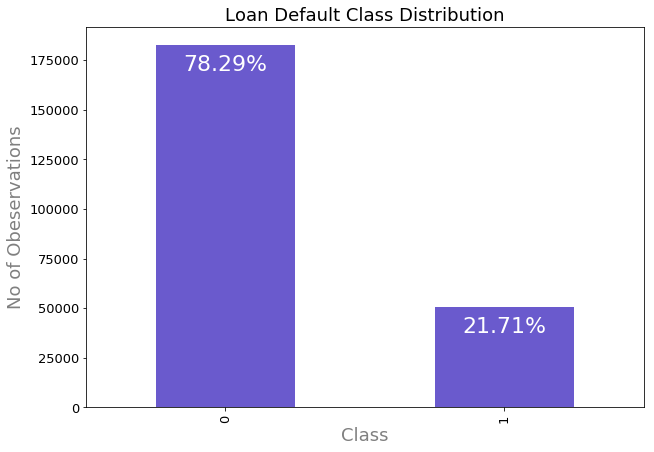

In [0]:
# Given Dataset 
ax = train_df['loan_default'].value_counts().plot(kind = 'bar', figsize = (10, 7), color = 'slateblue', fontsize = 13)
ax.set_alpha(0.8)
ax.set_xlabel('Class', color = 'gray', fontsize = 18 )
ax.set_ylabel('No of Obeservations', fontsize = 18, color = 'gray')
ax.set_title("Loan Default Class Distribution", fontsize = 18)

totals = []

for i in ax.patches:
  totals.append(i.get_height())
total = sum(totals)

print(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    
    ax.text(i.get_x() + 0.1, i.get_height()- 13000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=22,
                color='white')
  
plt.show()

In [0]:
train_df['loan_default'] = train_df['loan_default'].astype('category')

In [0]:
train_df.head(5)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [0]:
# No. of Vehicle Manufacturer 
len(train_df['manufacturer_id'].unique())

11

In [0]:
# Count of Loan defaults grouped by Employee Type
df = train_df.groupby(['Employment.Type', 'loan_default']).agg({'loan_default': 'count'})
df

loan_default
Employment.Type loan_default              
Salaried        0                    77948
                1                    19910
Self employed   0                    98578
                1                    29057

In [0]:

train_df.groupby(['State_ID', 'loan_default']).agg({'loan_default': 'count'})

loan_default
State_ID loan_default              
1        0                     7353
         1                     1583
2        0                     3031
         1                     1129
3        0                    27733
         1                     6345
4        0                    35544
         1                     9326
5        0                     8154
         1                     2023
6        0                    26615
         1                     6890
7        0                     5417
         1                     1369
8        0                    10939
         1                     3258
9        0                    12530
         1                     3492
10       0                     2972
         1                      633
11       0                     5348
         1                     1373
12       0                     3092
         1                     1118
13       0                    12401
         1                     5483
14       0                     6817
         1                     2597
15       0                     3981
         1                     1068
16       0                     2192
         1                      493
17       0                     3010
         1                      981
18       0                     4221
         1                     1191
19       0                      848
         1                      187
20       0                      153
         1                       32
21       0                      125
         1                       31
22       0                       67
         1                        9

In [0]:
train_df.head(5)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [0]:
train_df.columns 

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [0]:
len(train_df['PERFORM_CNS.SCORE.DESCRIPTION'].unique())

20

In [0]:
train_df['PERFORM_CNS.SCORE'].unique()

array([  0, 598, 305, 825,  17, 718, 818, 300, 786, 738, 688, 585, 615,
       750, 801, 730, 758, 768, 610, 653, 413, 709, 719,  16,  15, 701,
       626, 717, 692, 501, 693, 762, 749, 702,  18, 763, 599, 824, 575,
       607, 819, 841, 656, 836, 427, 687, 743, 783, 733, 708, 772, 650,
       342, 680, 676, 548, 429, 597, 663, 667, 792, 707, 798, 606, 681,
       830, 684, 686, 593, 746, 829, 651, 710, 573, 695, 671, 729, 879,
       603, 753, 502, 739, 605, 706, 657, 639, 785, 405, 690, 602, 635,
       630, 741, 625, 628, 766,  14, 809, 737, 722, 760, 640, 797, 505,
       774, 620, 728, 694, 679, 470, 823, 685, 832, 662, 627, 392, 643,
       727, 660, 705, 726, 796, 611, 771, 586, 839, 623, 700, 691, 793,
       752, 644, 734, 582, 437, 601, 703, 675, 755, 740, 810, 661, 324,
       759, 646, 659, 583, 440, 638, 490, 609, 721, 574, 673, 600, 784,
       652, 595, 777, 596, 655, 678, 713, 362, 466, 399, 426, 532, 386,
       821, 714, 508, 636, 537, 698, 590, 488, 608, 519, 398, 30

In [0]:
df = train_df[['PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION', 'loan_default']]
df.head(50)

,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,loan_default
0,0,No Bureau History Available,0
1,598,I-Medium Risk,1
2,0,No Bureau History Available,0
3,305,L-Very High Risk,1
4,0,No Bureau History Available,1
5,825,A-Very Low Risk,0
6,0,No Bureau History Available,0
7,17,Not Scored: Not Enough Info available on the c...,0
8,718,D-Very Low Risk,0
9,818,A-Very Low Risk,0


In [0]:
# Quantitative variables : [disbursed_amount, asset_cost, ltv, 
#                           Perform_CNS_Score, Perform_CNS_Score_DESC, 
#                            pri_NO_accts, active_acct, 
# 
# 
# 
# 
#                           NEW.ACCTS.IN.LAST.SIX.MONTHS, DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, NO.OF_INQUIRIES]

# Categoorical Variables : [branch_id, supplier_id, manufacturer_id, current_pincode, Employement.Type, 
#                           State_ID, MobileNo_AVL_Flag, Aadhar_Flag, PAN_flag, VoterID_flag, Driving_flag, Passport_flag,
#                            ]

# preprocess : [date.of.Birth, disbursalDate, CREDIT.HISTORY.LENGTH, AVERAGE.ACCT.AGE]
#
# Delete features : [Unique_ID, Employee_code_ID, ]

In [0]:
# preparing Quantitative variables



In [0]:
train_df.dtypes

UniqueID                                  int64
disbursed_amount                          int64
asset_cost                                int64
ltv                                     float64
branch_id                                 int64
supplier_id                               int64
manufacturer_id                           int64
Current_pincode_ID                        int64
Date.of.Birth                            object
Employment.Type                          object
DisbursalDate                            object
State_ID                                  int64
Employee_code_ID                          int64
MobileNo_Avl_Flag                         int64
Aadhar_flag                               int64
PAN_flag                                  int64
VoterID_flag                              int64
Driving_flag                              int64
Passport_flag                             int64
PERFORM_CNS.SCORE                         int64
PERFORM_CNS.SCORE.DESCRIPTION           

In [0]:
train_df.iloc[0]

UniqueID                                                    420825
disbursed_amount                                             50578
asset_cost                                                   58400
ltv                                                          89.55
branch_id                                                       67
supplier_id                                                  22807
manufacturer_id                                                 45
Current_pincode_ID                                            1441
Date.of.Birth                                             01-01-84
Employment.Type                                           Salaried
DisbursalDate                                             03-08-18
State_ID                                                         6
Employee_code_ID                                              1998
MobileNo_Avl_Flag                                                1
Aadhar_flag                                                   

In [0]:
train_df.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,...,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,...,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,...,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,...,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000


In [0]:
train_df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [0]:
drop_features = ['UniqueID', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Employee_code_ID',
                'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag',]

train_df = train_df.drop(drop_features, axis = 1)

In [0]:
train_df.shape

(233154, 29)

In [0]:
train_df.isnull().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
PRI.CURRENT.BALANCE                       0
PRI.SANCTIONED.AMOUNT                     0
PRI.DISBURSED.AMOUNT                      0
SEC.NO.OF.ACCTS                           0
SEC.ACTIVE.ACCTS                          0
SEC.OVERDUE.ACCTS                         0
SEC.CURRENT.BALANCE                       0
SEC.SANCTIONED.AMOUNT                     0
SEC.DISBURSED.AMOUNT                      0
PRIMARY.INSTAL.AMT                        0
SEC.INSTAL.AMT                  

In [0]:
train_df.dropna(inplace = True)

**Non Numneric data**

In [0]:
train_df.dtypes.value_counts()

int64       21
object       6
category     1
float64      1
dtype: int64

In [0]:
object_cols_df = train_df.select_dtypes(include = ['object'])
print(object_cols_df.iloc[0])

Date.of.Birth                                       01-01-84
Employment.Type                                     Salaried
DisbursalDate                                       03-08-18
PERFORM_CNS.SCORE.DESCRIPTION    No Bureau History Available
AVERAGE.ACCT.AGE                                   0yrs 0mon
CREDIT.HISTORY.LENGTH                              0yrs 0mon
Name: 0, dtype: object


In [0]:
# Date.of.Birth
from datetime import datetime 
from datetime import date 

def calAge(dob):
  age =  pd.to_datetime('today').year - pd.to_datetime(dob).year
  if age < 0:
    age = age + 100 
  return age 
    

train_df['Age'] = train_df['Date.of.Birth'].apply(calAge)
train_df = train_df.drop('Date.of.Birth', axis =  1)

In [0]:
# Employement.Type
dummy_df = pd.get_dummies(train_df['Employment.Type'])
train_df = pd.concat([train_df, dummy_df], axis = 1)
train_df = train_df.drop('Employment.Type', axis = 1)

In [0]:
# PERFORM_CNS.SCORE.DESCRIPTION 
dummy_df = pd.get_dummies(train_df['PERFORM_CNS.SCORE.DESCRIPTION'])
train_df = pd.concat([train_df, dummy_df], axis = 1)
train_df = train_df.drop('PERFORM_CNS.SCORE.DESCRIPTION', axis = 1)

In [0]:
# AVERAGE.ACCT.AGE & CREDIT.HISTORY.LENGTH 
import re 

def preprocess(str1):
  no = re.findall('\d+', str1)
  mylist = [12, 1]
  res = 0 
  for i,j in zip(no, mylist):
    i = int(i)
    res = res + (i*j)
  return res 

train_df['AVG_ACCT_AGE_Mon'] = train_df['AVERAGE.ACCT.AGE'].apply(preprocess)
train_df['CREDIT.HISTORY.LENGTH_Mon'] = train_df['CREDIT.HISTORY.LENGTH'].apply(preprocess)


In [0]:
train_df = train_df.drop(['AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH'], axis = 1)

In [0]:
train_df = train_df.drop('DisbursalDate', axis = 1)

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225493 entries, 0 to 233153
Data columns (total 48 columns):
disbursed_amount                                           225493 non-null int64
asset_cost                                                 225493 non-null int64
ltv                                                        225493 non-null float64
State_ID                                                   225493 non-null int64
PERFORM_CNS.SCORE                                          225493 non-null int64
PRI.NO.OF.ACCTS                                            225493 non-null int64
PRI.ACTIVE.ACCTS                                           225493 non-null int64
PRI.OVERDUE.ACCTS                                          225493 non-null int64
PRI.CURRENT.BALANCE                                        225493 non-null int64
PRI.SANCTIONED.AMOUNT                                      225493 non-null int64
PRI.DISBURSED.AMOUNT                                       225493 non-null in

In [0]:
train_df.head(10)

,disbursed_amount,asset_cost,ltv,State_ID,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,...,M-Very High Risk,No Bureau History Available,Not Scored: More than 50 active Accounts found,Not Scored: No Activity seen on the customer (Inactive),Not Scored: No Updates available in last 36 months,Not Scored: Not Enough Info available on the customer,Not Scored: Only a Guarantor,Not Scored: Sufficient History Not Available,AVG_ACCT_AGE_Mon,CREDIT.HISTORY.LENGTH_Mon
0,50578,58400,89.55,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,47145,65550,73.23,6,598,1,1,1,27600,50200,...,0,0,0,0,0,0,0,0,23,23
2,53278,61360,89.63,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,57513,66113,88.48,6,305,3,0,0,0,0,...,0,0,0,0,0,0,0,0,8,15
4,52378,60300,88.39,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,54513,61900,89.66,6,825,2,0,0,0,0,...,0,0,0,0,0,0,0,0,21,24
6,46349,61500,76.42,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,43894,61900,71.89,6,17,1,1,0,72879,74500,...,0,0,0,0,0,1,0,0,2,2
8,53713,61973,89.56,6,718,1,1,0,-41,365384,...,0,0,0,0,0,0,0,0,56,56
9,52603,61300,86.95,6,818,1,0,0,0,0,...,0,0,0,0,0,0,0,0,19,19


# Modelling 


In [0]:
# Logistic regression classifier 

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
cols = train_df.columns 
train_cols = cols.drop('loan_default')
features = train_df[train_cols]
target = train_df['loan_default']

lr.fit(features, target)
predictions = lr.predict(features)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
from sklearn.model_selection import 
lr = LogisticRegression()
kf = KFold(features.shape[0], random_state=42)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

NameError: ignored